In [35]:
import pickle
from collections import Counter
from itertools import product

import matplotlib
import matplotlib.patches as patches
import numpy as np
import torchvision.transforms as transforms
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch, ConnectionStyle
from PIL import Image

In [36]:
connectionstyle = ConnectionStyle("Arc3, rad=0.2")

display_transform     = transforms.Compose([transforms.Resize(240), transforms.CenterCrop((240, 240))])
display_transform_knn = transforms.Compose([transforms.Resize(256), transforms.CenterCrop((224, 224))])

In [37]:
def keep_top_k(input_array, K=5):
  """
  return top 5 (k) from numpy array
  """
  top_5 = np.sort(input_array.reshape(-1))[::-1][K-1]
  masked = np.zeros_like(input_array)
  masked[input_array>=top_5] = 1
  return masked


def arg_topK(inputarray, topK=5):
  """
  returns indicies related to top K element (largest)
  """
  return np.argsort(inputarray.T.reshape(-1))[::-1][:topK]

In [38]:
# FOR MULTI
def plot_from_reranker_output(reranker_output, draw_box=True, draw_arcs=True):
  """
  visualize chm results from a reranker output dict
  """
  
  ### SET COLORS
  cmap = matplotlib.cm.get_cmap('gist_rainbow')
  rgba = cmap(0.5)
  colors = []
  for k in range(5):
    colors.append(cmap(k/5.0))
  
  ### SET POINTS
  A = np.linspace(1+17, 240-17-1, 7)
  point_list = list(product(A, A))

  nrow = 4
  ncol = 7

  fig = plt.figure(figsize=(32, 18)) 
  gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 0.2, 1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1], wspace=0.1, hspace=0.1, top=0.9, bottom=0.05, left=0.17, right=0.845) 
  axes = [[None for n in range(ncol-1)] for x in range(nrow)]

  for i in range(4):
    axes[i] =[]
    for j in range(7):
      if j != 1:
        if (i, j) in [(2, 0), (3, 0)]:
          axes[i].append(new_ax)
        else:
          new_ax =  plt.subplot(gs[i,j])
          new_ax.set_xticklabels([])
          new_ax.set_xticks([])
          new_ax.set_yticklabels([])
          new_ax.set_yticks([]) 
          new_ax.axis('off')
          axes[i].append(new_ax)
        
  ##################### DRAW EVERYTHING
  axes[0][0].imshow(display_transform(Image.open(reranker_output['q']).convert('RGB')))
  axes[0][0].set_title(f'Query - K={reranker_output["K"]}, N={reranker_output["N"]}', fontsize=21)

  axes[1][0].imshow(display_transform(Image.open(reranker_output['q']).convert('RGB')))
  axes[1][0].set_title(f'Query - K={reranker_output["K"]}', fontsize=21)

  # axes[2][0].imshow(display_transform(Image.open(reranker_output['q'])))

  # CHM Top5
  for i in range(min(5, reranker_output['chm-prediction-confidence'])):
    axes[0][1+i].imshow(display_transform(Image.open(reranker_output['chm-nearest-neighbors'][i]).convert('RGB')))
    axes[0][1+i].set_title(f'CHM - Top - {i+1}', fontsize=21)

  if reranker_output['chm-prediction-confidence']<5:
    for i in range(reranker_output['chm-prediction-confidence'], 5):
      axes[0][1+i].imshow(Image.new(mode="RGB", size=(224, 224), color="white"))
      axes[0][1+i].set_title(f'', fontsize=21)

    
  # KNN top5
  for i in range(min(5, reranker_output['knn-prediction-confidence'])):
    axes[1][1+i].imshow(display_transform_knn(Image.open(reranker_output['knn-nearest-neighbors'][i]).convert('RGB')))
    axes[1][1+i].set_title(f'kNN - Top - {i+1}', fontsize=21)

    
    
  if reranker_output['knn-prediction-confidence']<5:
    for i in range(reranker_output['knn-prediction-confidence'], 5):
      axes[1][1+i].imshow(Image.new(mode="RGB", size=(240, 240), color="white"))
      axes[1][1+i].set_title(f'', fontsize=21)
    
  for i in range(min(5, reranker_output['chm-prediction-confidence'])):
    axes[2][i+1].imshow(display_transform(Image.open(reranker_output['q']).convert('RGB')))

  # Lower ROWs CHM Top5
  for i in range(min(5, reranker_output['chm-prediction-confidence'])):
    axes[3][1+i].imshow(display_transform(Image.open(reranker_output['chm-nearest-neighbors'][i]).convert('RGB')))

    
  if reranker_output['chm-prediction-confidence']<5:
    for i in range(reranker_output['chm-prediction-confidence'], 5):
      axes[2][i+1].imshow(Image.new(mode="RGB", size=(240, 240), color="white"))
      axes[3][1+i].imshow(Image.new(mode="RGB", size=(240, 240), color="white"))

  nzm = reranker_output['non_zero_mask']    
  # Go throught top 5 nearest images

  # #################################################################################
  if draw_box:
    # SQUARAES
    for NC in range(min(5, reranker_output['chm-prediction-confidence'])):
      # ON SOURCE
      valid_patches_source = arg_topK(reranker_output['masked_cos_values'][NC], topK=nzm) 
      
      # ON QUERY
      target_masked_patches =  arg_topK(reranker_output['masked_cos_values'][NC], topK=nzm) 
      valid_patches_target  = [reranker_output['correspondance_map'][NC][x] for x in target_masked_patches]
      valid_patches_target  = [(x[0]*7)+x[1] for x in valid_patches_target]

      patch_colors = [c for c in colors]
      overlaps = [item for item, count in Counter(valid_patches_target).items() if count > 1]
      
      for O in overlaps:
        indices = [i for i, val in enumerate(valid_patches_target) if val==O]
        for ii in indices[1:]:
          patch_colors[ii] = patch_colors[indices[0]]
      
      for i in valid_patches_source:
        Psource = point_list[i]
        rect = patches.Rectangle((Psource[0]-16, Psource[1]-16), 32, 32, linewidth=2, edgecolor=patch_colors[valid_patches_source.tolist().index(i)], facecolor='none', alpha=1)
        axes[2][1+NC].add_patch(rect)
    
      for i in valid_patches_target:
        Psource = point_list[i]
        rect = patches.Rectangle((Psource[0]-16, Psource[1]-16), 32, 32, linewidth=2, edgecolor=patch_colors[valid_patches_target.index(i)], facecolor='none', alpha=1)
        axes[3][1+NC].add_patch(rect)  


  #################################################################################
  # Show correspondence lines and points
  if draw_arcs:
    for CK in range(min(5, reranker_output['chm-prediction-confidence'])):
      target_keypoints = []
      topk_index = arg_topK(reranker_output['masked_cos_values'][CK], topK=nzm)
      for i in range(nzm): # Number of Connections
        con = ConnectionPatch(xyA=(reranker_output['src-keypoints'][CK][i, 0], reranker_output['src-keypoints'][CK][i, 1]),
                              xyB=(reranker_output['tgt-keypoints'][CK][i, 0], reranker_output['tgt-keypoints'][CK][i, 1]), 
                              coordsA="data", 
                              coordsB="data",
                              axesA=axes[2][1+CK], axesB=axes[3][1+CK], color=colors[i], connectionstyle=connectionstyle, 
                              shrinkA=1.0, shrinkB=1.0,  linewidth=1)

        axes[3][1+CK].add_artist(con)

      # Scatter Plot
      axes[2][1+CK].scatter(reranker_output['src-keypoints'][CK][:, 0], reranker_output['src-keypoints'][CK][:, 1], c=colors[:nzm], s=10)
      axes[3][1+CK].scatter(reranker_output['tgt-keypoints'][CK][:, 0], reranker_output['tgt-keypoints'][CK][:, 1], c=colors[:nzm], s=10)

  title_colors = ['black']
  
  if reranker_output['gt_name']== reranker_output['chm-prediction']:
    title_colors.append('green')
  else:
     title_colors.append('red')
  
  if reranker_output['gt_name']== reranker_output['knn-prediction']:
    title_colors.append('green')
  else:
     title_colors.append('red')
  
  fig.text(0.15, 0.95, f"GT: {reranker_output['gt_name']}", ha="left", va="bottom", color=title_colors[0], fontsize=22)
  fig.text(0.5, 0.95, f"CHM: {reranker_output['chm-prediction']}" , ha="center", va="bottom",  color=title_colors[1], fontsize=22)
  fig.text(0.8, 0.95, f"KNN: {reranker_output['knn-prediction']}" , ha="right", va="bottom", color=title_colors[2], fontsize=22)

  return fig

In [42]:
with open('/home/mohammad/src/tmp/reranker_34.pkl', 'rb') as f:
  chm_result = pickle.load(f)

In [43]:
chm_result.keys()

dict_keys(['id', 'q', 'gt_name', 'gt_wnid', 'K', 'N', 'knn-prediction', 'knn-prediction-confidence', 'knn-nearest-neighbors', 'knn-nearest-neighbors-all', 'chm-prediction', 'chm-prediction-confidence', 'chm-nearest-neighbors', 'chm-nearest-neighbors-all', 'correspondance_map', 'masked_cos_values', 'src-keypoints', 'tgt-keypoints', 'non_zero_mask', 'transferred_kpoints'])

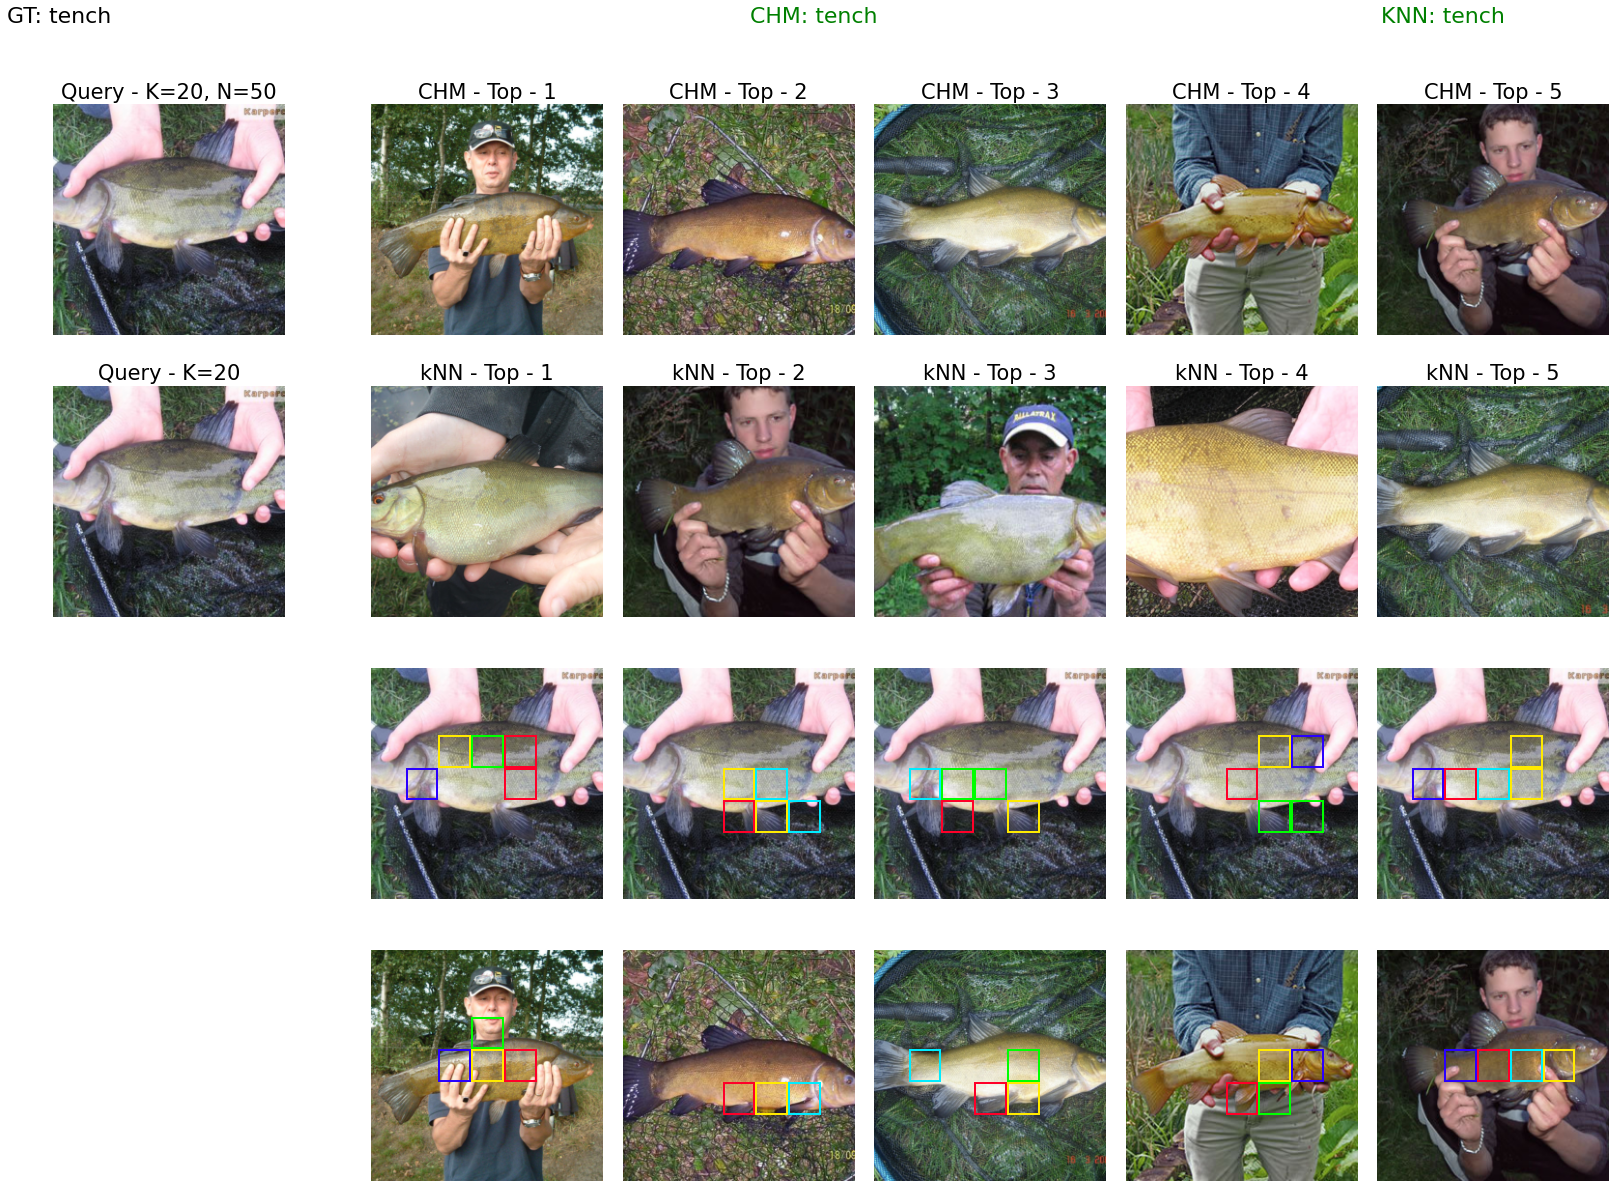

In [44]:
plot_from_reranker_output(chm_result, draw_arcs=False)
plt.show()